# Optical Flow
## Coded By: Abhinav Gupta, 20171059
- We implement the **Lucas Kanade algorithm** to compute the optical flow between images.- 
- The idea behind Lucas Kanade is to find movement of pixels in the 2 frames by finding the least square solution on a vector using the gradient in the x&y directions which would help predict the movement of the pixels.
- We use the computed flow to detect, segment and track objects in videos. 

- As usual, let's first import all the libraries that we require. 
- It's mostly the same, we import an extra `from scipy import signal` as that is going to help us in convolution. 

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from PIL import Image
import sys
import os
from scipy import signal
import glob
import scipy

### Lucas-Kanade Algorithm
- We write our `optical_flow` function which computes the optical flow using the Lucas Kanade algorithm. 
- The function takes as input the two images in grayscale and the window size. 
- We define our kernels in x,y and t to compute the intensity gradients using the `conv2d` function. 
- And then we calculate the vectors (u,v) within each window with the help of SVD decomposition. 
- Check this amazing tutorial out for more: [link to tutorial](https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/)

In [44]:
def optical_flow(I1g, I2g, window_size, tau=1e-2):
    #Define our kernels to calculate gradients
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    
    # Implementing Lucas Kanade
    # For each point, we calculate I_x, I_y, I_t by conv2d
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode='same') + \
        scipy.signal.convolve2d(I1g, -kernel_t, boundary='symm', mode='same')
    
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    
    # For each window calculate the vectors [u,v], within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            
            A = [ [np.sum(Ix*Ix),np.sum(Ix*Iy)], [np.sum(Iy*Ix), np.sum(Iy*Iy)] ]
            A = np.array(A)
    
            b = [-np.sum(Ix*It), -np.sum(Iy*It)]
            b = np.array(b)
            
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            U,D,V_T = np.linalg.svd(A.T.dot(A))
            if np.min(D) < tau:
                u[i,j]=0
                v[i,j]=0                
            
            else:
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)
                
    return [u,v]

- We have been given the famous Middlebury optical flow dataset. Let's take the dumptruck images and load them. 

In [45]:
img1 = cv2.imread('./data/Dumptruck/frame10.png')
img2 = cv2.imread('./data/Dumptruck/frame11.png')
img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

- This is what the images look like: a scene on the road where the right image is in sequence after the left images. 
- We need to compute the flow between these two images to find how much the pixels have moved. 

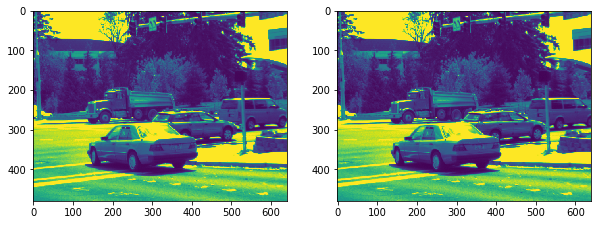

In [61]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(img1g)
f.add_subplot(1,2, 2)
plt.imshow(img2g)
plt.show()

We compute the flow between these two images using the function above that implements lucas-kanade algorithm.

In [49]:
u1,v1 = optical_flow(img1g, img2g, 15)

#### Displaying the vectors
- We write a neat function to help plot the (u,v) vectors obtained above. 
- The first two subplots are simply the two images we are interested in finding the optical flow between. 
- The next two plots are the (u,v) vectors we computed using lucas-kanade.
- We also plot the magnitude and the angle between u and v.

In [64]:
def plot_vectors(im1,im2,u,v,fig_size=(10,10),arrow_thres=0.02):
    
    fig = plt.figure(figsize=fig_size)
    
    # Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("First Image")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Second Image")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U Vector")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V Vector")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='gray')
    ax.set_title("Magnitude: U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("Angle: arc(v/u)")
    ax.axis('off')
    
    plt.show()
    
    return None

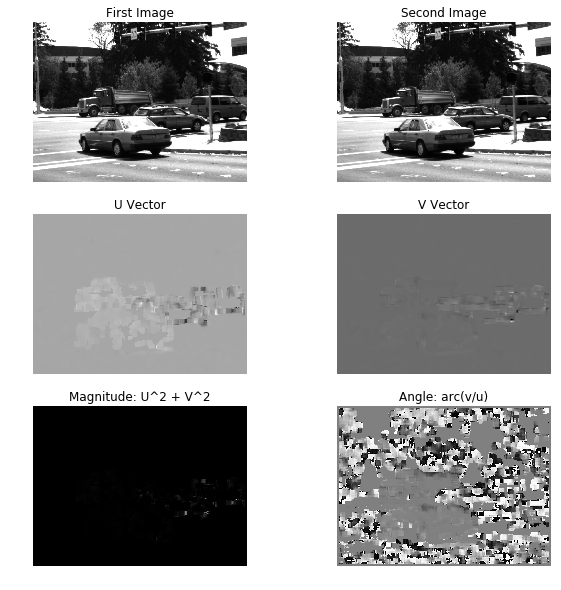

In [65]:
plot_vectors(img1g,img2g,u1,v1)

### Segmentation Mask 
- Now let's plot the flow mask as well. 
- We do this by checking if the magnitude of the vectors is more than a particular threshold, and accordingly give it white/black colour to get a binary segmentation. 

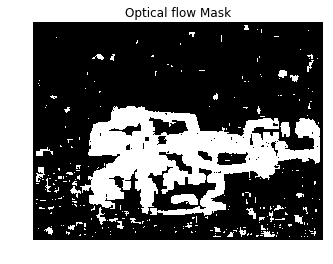

In [66]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow( (u1*u1 + v1*v1>0.02),cmap='gray')
ax.set_title("Optical flow Mask")
ax.axis('off')
plt.show()

- As we can see in the mask for dumptruck images, it's not a great segmentation as there is a lot of noise. **That's because we aren't dealing with larger movements.**
- **Lucas Kanade only works for smaller movements.** We need to use the pyramid based LK method for that. 

### Plotting the flow arrows
- Let's also plot the arrows to indicate the direction of movement. 
- We use OpenCV's inbuilt function `cv2.goodFeaturesToTrack` to obtain the significant features in the image and we plot arrows for those. 
- This is a 'sparse' computation, because we aren't using every pixel in the image. 

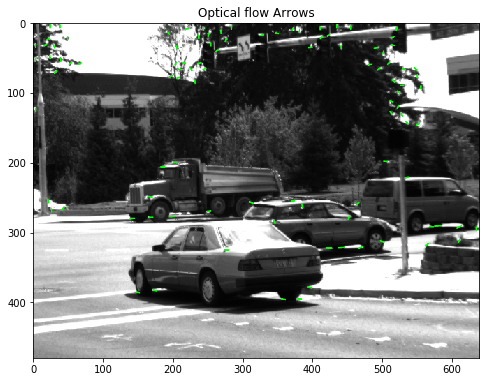

In [67]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(img1g,cmap='gray')
ax.set_title("Optical flow Arrows")

kp = cv2.goodFeaturesToTrack(img1g, 100, 0.01, 10, 3)
for arrow_ind in kp:
    x,y = arrow_ind[0]
    y = int(y)
    x = int(x)
    ax.arrow(x,y,u1[y,x],v1[y,x],head_width = 1, head_length = 5, color = (0,1,0))
plt.show()

#### Looks pretty cool, doesn't it? ^_^

### Results on the other images

- Now let's compute flow for some other image pairs in the Middlebury dataset and plot the arrows and get the segmentation masks! 
- We write a function that takes as input the two images and the computed vectors (u,v) from the lucas kanade algorithm and plots the segmentation mask and flow arrows as shown previously! 

In [99]:
def plot_results(img1, img2, u, v):
    f = plt.figure(figsize=(10,10))

    f.add_subplot(1,2, 1)
    plt.imshow(img1)
    f.add_subplot(1,2, 2)
    plt.imshow(img2)

    # For the mask and flow arrows
    fig = plt.figure(figsize=(15,15))
    
    ax = fig.add_subplot(1,2, 1)
    ax.imshow( (u*u + v*v>0.02),cmap='gray')
    ax.set_title("Optical flow Mask")
    ax.axis('off')

    ax = fig.add_subplot(1,2, 2)
    ax.imshow(img1,cmap='gray')
    ax.set_title("Optical flow Arrows")

    kp = cv2.goodFeaturesToTrack(img1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 1, head_length = 5, color = (0,1,0))

    plt.show()

In [91]:
# Backyard
img1_backyard = cv2.imread('./data/Backyard/frame10.png')
img2_backyard = cv2.imread('./data/Backyard/frame11.png')

# convert to grayscale
img1_backyard = cv2.cvtColor(img1_backyard, cv2.COLOR_BGR2GRAY)
img2_backyard = cv2.cvtColor(img2_backyard, cv2.COLOR_BGR2GRAY)

u2,v2 = optical_flow(img1_backyard, img2_backyard, 15)

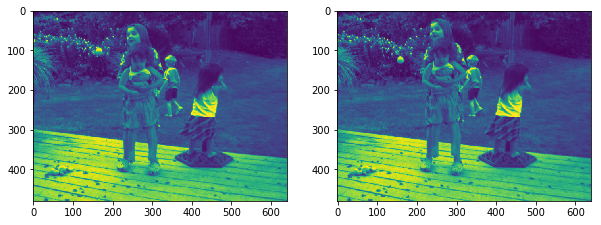

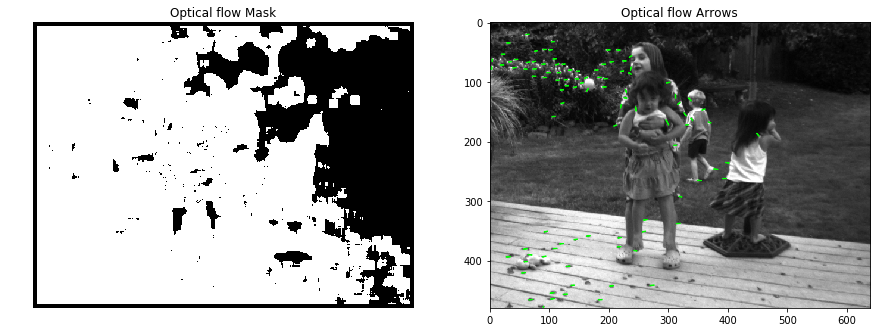

In [100]:
plot_results(img1_backyard, img2_backyard, u2, v2)

In [93]:
# Teddy
img1_teddy = cv2.imread('./data/Teddy/frame10.png')
img2_teddy = cv2.imread('./data/Teddy/frame11.png')

# convert to grayscale
img1_teddy = cv2.cvtColor(img1_teddy, cv2.COLOR_BGR2GRAY)
img2_teddy = cv2.cvtColor(img2_teddy, cv2.COLOR_BGR2GRAY)

u3,v3 = optical_flow(img1_teddy, img2_teddy, 15)

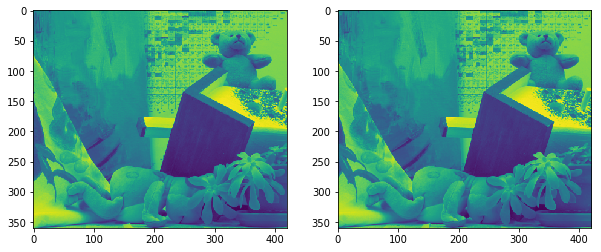

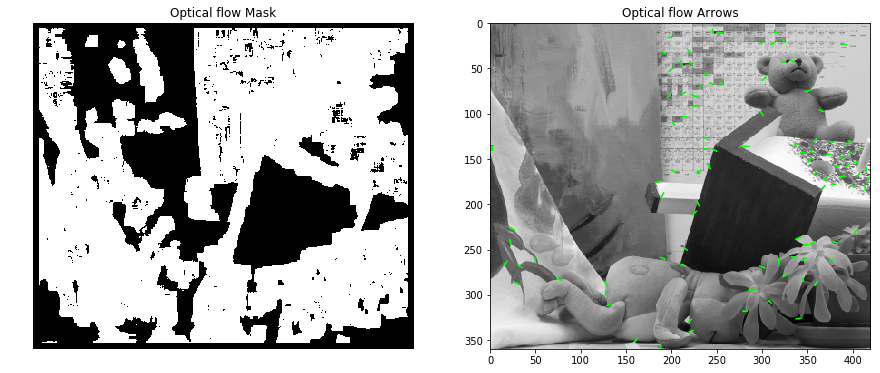

In [101]:
plot_results(img1_teddy, img2_teddy, u3, v3)

In [97]:
# Urban
img1_urban = cv2.imread('./data/Urban/frame10.png')
img2_urban = cv2.imread('./data/Urban/frame11.png')

# convert to grayscale
img1_urban = cv2.cvtColor(img1_urban, cv2.COLOR_BGR2GRAY)
img2_urban = cv2.cvtColor(img2_urban, cv2.COLOR_BGR2GRAY)

u4,v4 = optical_flow(img1_urban, img2_urban, 15)

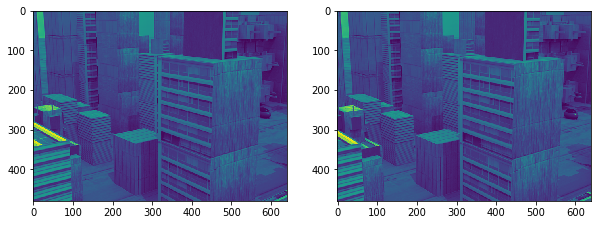

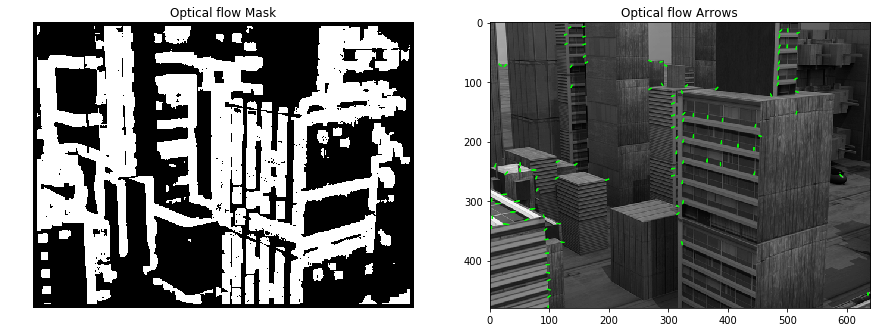

In [102]:
plot_results(img1_urban, img2_urban, u4, v4)

#### There was lesser movement in these frames and the image was more symmetrical, so we get some decent results :) 
- Another observation we make is that in cases where the camera is moving, the entire scene gets segmented out.
- Whereas if only the object moves, then only the object gets gets segmented out!

### Object Segmentation using Optical Flow
- We can also use optical flow to help segment moving objects in a video. 
- This can be done with the help of the segmentation masks that we have gotten above. 
- For this, I take a video of my bedroom at home and try to perform object segmentation. 

First, let's break down the video into individual frames. Let's use the same code snippet from the 'chroma keying' assignment. 

In [7]:
# Create a VideoCapture object 
# 0 for webcam
cap = cv2.VideoCapture('./data/my-room.MOV')
count = 0

if (cap.isOpened()== False): 
  print("Error")

- Capture the video frame by frame and save each individual frame into the 'frames' folder. 
- Hence, we break down the video into its constituent images. 

In [8]:
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  
  if ret == True:
    name = './frames/frame' + str(count) + '.jpg'
    print ('Creating...' + name) 
    cv2.imwrite(name, frame)
    cv2.imshow('Frame', frame)
    count+=1

    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
cap.release()
cv2.destroyAllWindows()

Creating..../frames/frame0.jpg
Creating..../frames/frame1.jpg
Creating..../frames/frame2.jpg
Creating..../frames/frame3.jpg
Creating..../frames/frame4.jpg
Creating..../frames/frame5.jpg
Creating..../frames/frame6.jpg
Creating..../frames/frame7.jpg
Creating..../frames/frame8.jpg
Creating..../frames/frame9.jpg
Creating..../frames/frame10.jpg
Creating..../frames/frame11.jpg
Creating..../frames/frame12.jpg
Creating..../frames/frame13.jpg
Creating..../frames/frame14.jpg
Creating..../frames/frame15.jpg
Creating..../frames/frame16.jpg
Creating..../frames/frame17.jpg
Creating..../frames/frame18.jpg
Creating..../frames/frame19.jpg
Creating..../frames/frame20.jpg
Creating..../frames/frame21.jpg
Creating..../frames/frame22.jpg
Creating..../frames/frame23.jpg
Creating..../frames/frame24.jpg
Creating..../frames/frame25.jpg
Creating..../frames/frame26.jpg
Creating..../frames/frame27.jpg
Creating..../frames/frame28.jpg
Creating..../frames/frame29.jpg
Creating..../frames/frame30.jpg
Creating..../frame

Creating..../frames/frame252.jpg
Creating..../frames/frame253.jpg
Creating..../frames/frame254.jpg
Creating..../frames/frame255.jpg
Creating..../frames/frame256.jpg
Creating..../frames/frame257.jpg
Creating..../frames/frame258.jpg
Creating..../frames/frame259.jpg
Creating..../frames/frame260.jpg
Creating..../frames/frame261.jpg
Creating..../frames/frame262.jpg
Creating..../frames/frame263.jpg
Creating..../frames/frame264.jpg
Creating..../frames/frame265.jpg
Creating..../frames/frame266.jpg
Creating..../frames/frame267.jpg
Creating..../frames/frame268.jpg
Creating..../frames/frame269.jpg
Creating..../frames/frame270.jpg
Creating..../frames/frame271.jpg
Creating..../frames/frame272.jpg
Creating..../frames/frame273.jpg
Creating..../frames/frame274.jpg
Creating..../frames/frame275.jpg
Creating..../frames/frame276.jpg
Creating..../frames/frame277.jpg
Creating..../frames/frame278.jpg
Creating..../frames/frame279.jpg
Creating..../frames/frame280.jpg
Creating..../frames/frame281.jpg
Creating..

### Results on my bedroom images
- Let's quickly take some sample frame from the video of my bedroom and see if we are able to get the optical flow. 
- Since the video is moving extremely slowly, let's take images that are 20 frames apart. 

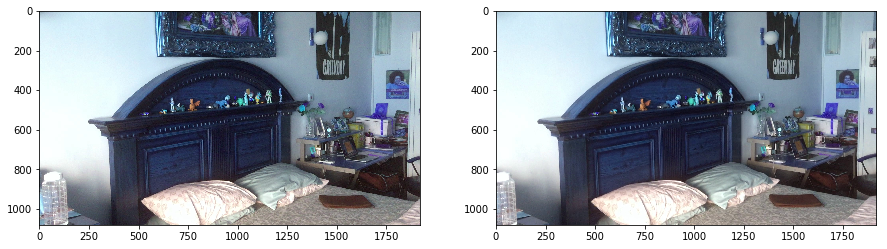

In [116]:
img1_bedroom = cv2.imread('./frames/frame0.jpg')
img2_bedroom = cv2.imread('./frames/frame20.jpg')
f = plt.figure(figsize=(15,15))
f.add_subplot(1,2, 1)
plt.imshow(img1_bedroom)
f.add_subplot(1,2, 2)
plt.imshow(img2_bedroom)

In [113]:
img1_bedroom = cv2.cvtColor(img1_bedroom, cv2.COLOR_BGR2GRAY)
img2_bedroom = cv2.cvtColor(img2_bedroom, cv2.COLOR_BGR2GRAY)
u5,v5 = optical_flow(img1_bedroom, img2_bedroom, 15)

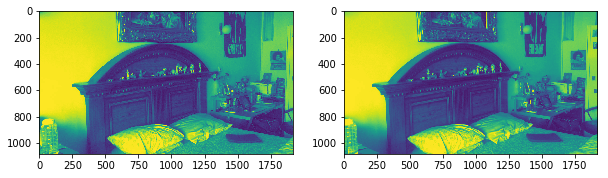

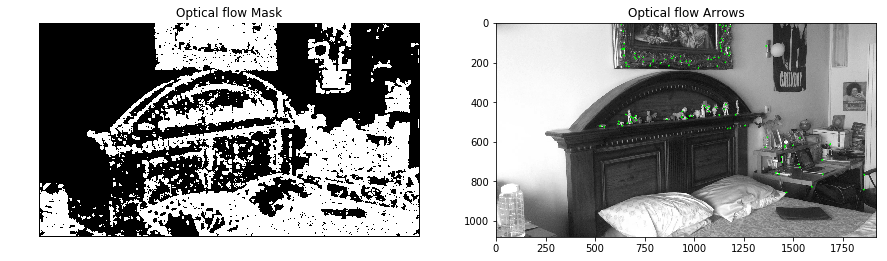

In [114]:
plot_results(img1_bedroom, img2_bedroom, u5, v5)

#### Looks amazing <3 Although it takes a lot of time to compute (u,v). 

- Now let's do it for consecutive frames in the video. 
- We loop over the frames, compute the (u,v) vectors and save the segmentation masks. 

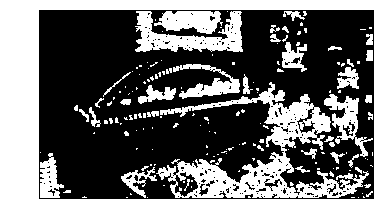

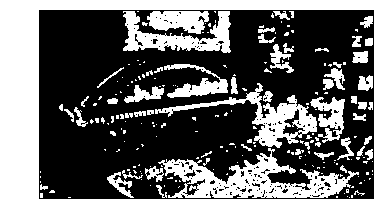

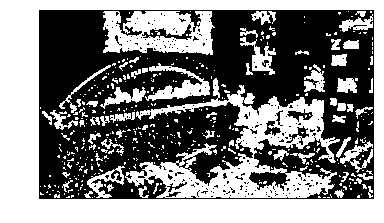

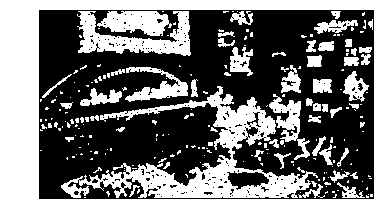

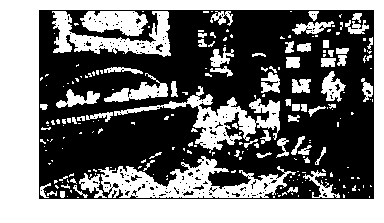

In [40]:
ctr = 1
for i in range(20,101,20):
    finalname1 = './frames/frame' + str(i) + '.jpg'
    img1 = cv2.imread(finalname1)
    finalname2 = './frames/frame' + str(i+20) + '.jpg'
    img2 = cv2.imread(finalname2)
    
    img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    u,v = optical_flow(img1g, img2g, 15)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    ax.imshow( (u*u + v*v>0.02),cmap='gray')
    ax.axis('off')
    
    output_name = './output-masks/mask' + str(ctr) + '.jpg'
    plt.savefig(output_name)
    ctr = ctr+1
    

- Yay, it worked! And it looks decent too, but it takes a lot of time :( 
- We now have the segmentation masks for the image frames of the video. Now let's combine these images together to make it into a video! 
- Again, we use the same code that we wrote for the 'chroma-keying' assignment that generates videos from the constituent images. 
- The scripts are attached in the folder as `convert1.py` and `convert2.py`. We run these individuall to combine the frames into 2 videos. 
- We then use iMovie to play these videos side by side. Here's the final video: [link to results](https://iiitaphyd-my.sharepoint.com/:v:/g/personal/abhinav_g_students_iiit_ac_in/EaFMPpy3ELhEpKqJ-BHhM3oBWBUk-fA8ac6lv5-hoyImiA?e=4q5l13)

### Object Tracking using Optical Flow
- We use OpenCV's inbuilt function `cv2.calcOpticalFlowPyrLK()` for this. [Link to documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html)
- Here, we create a simple application which tracks some points in a video. To decide the points, we use cv2.goodFeaturesToTrack(). 
- We take the first frame, detect some Shi-Tomasi corner points in it, then we iteratively track those points using Lucas-Kanade optical flow. 
- For the function cv2.calcOpticalFlowPyrLK() we pass the previous frame, previous points and next frame. It returns next points along with some status numbers which has a value of 1 if next point is found, else zero. We iteratively pass these next points as previous points in next step. 

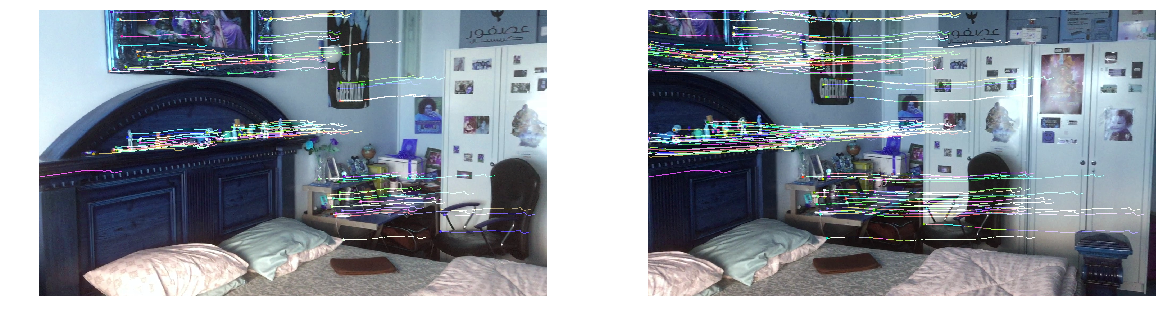

In [123]:
img1_tracking = cv2.imread('./output-tracking/75.jpg')
img2_tracking = cv2.imread('./output-tracking/164.jpg')
img3_tracking = cv2.imread('./output-tracking/254.jpg')
img4_tracking = cv2.imread('./output-tracking/331.jpg')

f = plt.figure(figsize=(20,20))
f.add_subplot(1,2, 1)
plt.axis('off')
plt.imshow(img1_tracking)

f.add_subplot(1,2, 2)
plt.axis('off')
plt.imshow(img2_tracking)

plt.show()

- Check out `tracking.py`, which contains the code for tracking points in the video using optical flow. 
- This code works really fast, as compared to our optical flow function. 
- We save the images, and generate a video using `convert3.py`. 
- It was taking too much time to upload to one drive, so I displayed the image results above. 